# **Задание Lite**

Взяв за основу ГА из занятия, нарастите сложность сверточной сети, которая генерируется.

1. Сделайте возможность бота создать любую последовательность слоев. Количество слоев должно задаваться ботом.

2. Можно жёстко настроить появление Flatten и полносвязные слои только в конце.

3. Полносвязные слои ГА также может генерить в произвольном количестве (количество слоев содержиться в боте).

# Подключение библиотек

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MAE
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from PIL import Image
from google.colab import files
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка данных

In [3]:
# Загружаем данные
base_data = pd.read_csv('/content/drive/MyDrive/УИИ/Генетические алгоритмы для обучения нейронных сетей/traff.csv', header=None)

In [4]:
# Проверка
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [5]:
# Возьмем все значения 1 столбца
data = base_data.iloc[:,1]

In [6]:
data

0       22,226.00
1       29,593.00
2       31,726.00
3       32,684.00
4       31,820.00
          ...    
1090    29,801.00
1091    34,913.00
1092    37,665.00
1093    32,643.00
1094    28,212.00
Name: 1, Length: 1095, dtype: object

In [7]:
# Превращаем в numpy массив
data = np.array(data)
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

In [8]:
print(data)
print(data.shape)

[22226.0 29593.0 31726.0 ... 37665.0 32643.0 28212.0]
(1095,)


## Преобразование данных

In [9]:
 xLen = 60                          # Анализируем по 60 прошедшим точкам 
 valLen = 300                       # Используем 300 записей для проверки

 trainLen = data.shape[0] - valLen  # Размер тренировочной выборки

 # Делим данные на тренировочную и тестовую выборки 
 Train = np.reshape(data[:trainLen], (-1,1))
 Test = np.reshape(data[trainLen+xLen+2:], (-1,1))

 print(Train.shape)
 print(Test.shape)

(795, 1)
(238, 1)


In [10]:
# Нормализуем данные
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

print(Train[0])
print(Test[0])

[0.4365639]
[0.17484173]


In [11]:
# Создаем генератор для обучения и теста
trainDataGen = TimeseriesGenerator(Train, Train, length=xLen, sampling_rate=1, batch_size=20)

testDataGen  = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)

## Функции

In [12]:
# Функция получения родителей
def getParents(curr_popul, nsurv):
  indexp1 = random.randint(0, nsurv - 1)
  indexp2 = random.randint(0, nsurv - 1)
  botp1 = curr_popul[indexp1]
  botp2 = curr_popul[indexp2]
  return botp1, botp2

In [13]:
# Функция смешивания (кроссинговера) двух родителей
def crossPointFrom2Parents(botp1, botp2, j):
  index = random.random()
  if index < 0.5:
    x = botp1[j]
  else:
    x = botp2[j]
  return x

In [14]:
# Функция результат прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

In [15]:
# Функция визуализации графиков
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значения')
  plt.legend()
  plt.show()

In [16]:
# Функция расёта корреляции
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a * b).mean()
  sa = a.std()
  sb = b.std()
  val = 0
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma * mb) / (sa * sb)
  return val

In [17]:
# Функция отображения корреляцию прогнозированного сигнала с правильным
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf=True, returnData=False):
  for ch in channels:
    yLen = yValUnscaled.shape[0]

    corr = []
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i, ch], predVal[i:, ch]))
    
    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i, ch], yValUnscaled[i:, ch]))
    
    if showGraf:
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')
  
  if showGraf:
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
  
  if returnData:
    return corr, own_corr

## Генерируем проверочную выборку

In [47]:
DataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=len(Test))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

print(xVal.shape)
print(yVal.shape)


(1, 178, 60, 1)
(1, 178, 1)


# Подбор архитектуры с помощью ГА

In [19]:
# Функция создания списка случайных параметров с учетом задания
def createRandomNet():
  net = []
  net.append(random.randint(0,1))   # 0  - Будет ли Нормализация 0,1
  net.append(random.randint(3,8))   # 1  - Первый свёрточный слой 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  net.append(random.randint(2,6))   # 2  - Ядро первого свёрточного слоя (2,3,4,5,6)
  net.append(random.randint(0,4))   # 3  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 4  - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 5  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  net.append(random.randint(0,1))   # 6  - Будет ли MaxPooling 0,1 
  net.append(random.randint(2,4))   # 7  - Ядро свертки MaxPooling


  net.append(random.randint(1,3))   # 8  - Определяем кол-во последовательных слоев от 1 до 3 Conv1D (слои будут создаваться в цикле)
  net.append(random.randint(0,1))   # 9  - Будет ли Нормализация 0,1
  net.append(random.randint(3,8))   # 10 - Кол-во фильтров в последующий Conv1D слоях 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  net.append(random.randint(2,6))   # 11 - Ядро первого свёрточного слоя (2,3,4,5,6)
  net.append(random.randint(0,4))   # 12 - Функция активации следующих слоев - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 13 - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 14 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  net.append(random.randint(0,1))   # 15 - Будет ли MaxPooling 0,1 
  net.append(random.randint(2,4))   # 16 - Ядро свертки MaxPooling

  net.append(random.randint(1,3))   # 17 - Определяем кол-во Dense слоев от 1 до 4 (слои будут создаваться в цикле)
  net.append(random.randint(0,1))   # 18 - Будет ли Нормализация 0,1
  net.append(random.randint(3,10))  # 19 - Кол-во нейронов в Dense слое  2 ** (3,4,5,6,7,8,9,10) - 8, 16, 32, 64, 128, 256, 512, 1024
  net.append(random.randint(0,4))   # 20  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  net.append(random.randint(0,1))   # 21  - Будет ли Dropout 0,1
  net.append(random.randint(0,3))   # 22  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)

  net.append(random.randint(0,4))   # 23  - Функция активации выходного слоя - ['linear','relu','tanh','softmax','sigmoid']
  
  return net

In [110]:
# Функция создания модели
def createConvNet(net):

  makeFirstNormalization = net[0]      # 0 - Нормализация в начале 0,1
  firstConvSize = 2 ** net[1]          # 1 - Первый Conv1D от 8 до 256 нейронов
  firstConvKernel = net[2]             # 2 - Ядро первого Conv1D - 2,3,4,5,6
  activation1 = net[3]                 # 3 - Функция активации, первого слоя ['linear','relu','tanh','softmax','sigmoid']
  makeDropOut1 = net[4]                # 4 - Будет ли Dropout 0,1
  firstDropout = net[5]                # 5 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  makePool1 = net[6]                   # 6  - Будет ли MaxPooling 0,1
  firstMaxPoolKernel = net[7]          # 7  - Ядро свертки MaxPooling

  nextLayersConv1D = net[8]            # 8  - Определяем кол-во последовательных слоев от 1 до 4 Conv1D (слои будут создаваться в цикле)
  makeConvNormalization = net[9]       # 9  - Будет ли Нормализация 0,1
  secondConvSize = 2 ** net[10]        # 10 - Кол-во фильтров в последующий Conv1D слоях 2 ** (3,4,5,6,7,8) - 8, 16, 32, 64, 128, 256 - фильтров
  secondConvKernel = net[11]           # 11 - Ядро первого свёрточного слоя (2,3,4,5,6)
  activation2 = net[12]                # 12 - Функция активации следующих слоев - ['linear','relu','tanh','softmax','sigmoid']
  makeDropOut2 = net[13]               # 13 - Будет ли Dropout 0,1
  secondDropout = net[14]              # 14 - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  makePool2 = net[15]                  # 15 - Будет ли MaxPooling 0,1 
  secondMaxPoolKernel = net[16]        # 16 - Ядро свертки MaxPooling

  nextLayersDense = net[17]            # 17 - Определяем кол-во Dense слоев от 1 до 4 (слои будут создаваться в цикле)
  makeDenseNormalization = net[18]     # 18 - Будет ли Нормализация 0,1
  sizeDense = net[19]                  # 19 - Кол-во нейронов в Dense слое  2 ** (3,4,5,6,7,8,9,10) - 8, 16, 32, 64, 128, 256, 512, 1024
  activation3 = net[20]                # 20  - Функция активации первого слоя - ['linear','relu','tanh','softmax','sigmoid']
  makeDropout3 = net[21]               # 21  - Будет ли Dropout 0,1
  thirdDropout = net[22]               # 22  - Установка параметра rate в слое Dropout (0.25, 0.3, 0.35, 0.4)
  activation4 = net[23]                # 23  - Функция активации выходного слоя - ['linear','relu','tanh','softmax','sigmoid']
 
  shape = (xLen, 1)
  inputs = Input(shape)

  activation_list = ['linear', 'relu', 'tanh', 'softmax', 'sigmoid']
  dropout_list = [0.25, 0.3, 0.35, 0.4]

  if makeFirstNormalization:
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize, firstConvKernel, padding='same')(x)
    x = Activation(activation_list[activation1])(x)
  else:
    x = Conv1D(firstConvSize, firstConvKernel, padding='same')(inputs)
    x = Activation(activation_list[activation1])(x)
  
  if makeDropOut1:
    x = Dropout(dropout_list[firstDropout])(x)
  
  if makePool1:
    x = MaxPooling1D(firstMaxPoolKernel)(x)

  
  # Цикл для добавления произвольных слоев Conv1D

  for i in range(nextLayersConv1D):    # Добавляем следующие Conv1D слои с помощью цикла

    if makeConvNormalization:
      x = BatchNormalization()(x)

    x = Conv1D(secondConvSize, secondConvKernel, padding='same')(x)
    x = Activation(activation_list[activation2])(x)

    if makeDropOut2:
      x = Dropout(dropout_list[secondDropout])(x) 
    
    # if makePool2:
    #   x = MaxPooling1D(secondMaxPoolKernel)(x)

  x = Flatten()(x)

  for i in range(nextLayersDense):
    if makeDenseNormalization:
      x = BatchNormalization()(x)
    
    x = Dense(2**sizeDense)(x)
    x = Activation(activation_list[activation3])(x)

    if makeDropout3:
      x = Dropout(dropout_list[thirdDropout])(x) 
      

  fin = Dense(1)(x)
  fin = Activation(activation_list[activation4])(fin)

  model = Model(inputs, fin)
  return model

In [107]:
# Функция вычисления результата

def evaluateNet(net, ep=10, verb=False):
  val = 0
  model = createConvNet(net)
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
  history = model.fit(trainDataGen, epochs=ep, verbose=verb, validation_data=testDataGen)
  val = history.history['val_loss'][-1]

  return val

In [23]:
# Проверка
# popul = [createRandomNet() for _ in range(n)]
# print(popul[0])
# #for i in range(1):
# model = createConvNet(popul[1])
# print()
# model.summary()
# plot_model(model, show_shapes=True, dpi = 70)

## Реализация алгоритма

In [108]:
n = 30           # Общее число ботов
nsurv = 10       # Кол-во выживших
nnew = n - nsurv # Кол-во новых
l = 24           # Размер бота
epochs = 20      # Количество эпох

mut = 0.1       # Коэфициент мутаций

In [111]:
popul = []
val = []

# Создаем случайных ботов
popul = [createRandomNet() for _ in range(n)]

for ep in range(epochs):
  val = []
  curr_time = time.time()

  for i in range(n):
    bot = popul[i]
    f = evaluateNet(bot)
    val.append(f)
  
  # Сортируем val
  sval = sorted(val, reverse=False)

  # Вывод
  end_time = time.time() - curr_time
  print(f'{ep} время: {round(end_time, 2)} ---- Лучшие результаты: {sval[:5]}  ----- Лучшие боты: {popul[:2]}')

  newpopul = [] # Новая популяция
  for i in range(nsurv):
    index = val.index(sval[i])
    newpopul.append(popul[index])
  
  for i in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []
    net4Mut = createRandomNet()

    for j in range(l):
      x = crossPointFrom2Parents(botp1, botp2, j)
      if random.random() < mut:
        x = net4Mut[j]
      newbot.append(x)
    newpopul.append(newbot)

  popul = newpopul

0 время: 154.19 ---- Лучшие результаты: [0.046875402331352234, 0.05585693567991257, 0.058673109859228134, 0.05894402787089348, 0.059067074209451675]  ----- Лучшие боты: [[1, 3, 6, 1, 1, 1, 0, 3, 1, 1, 5, 4, 1, 0, 1, 1, 2, 2, 1, 10, 2, 1, 1, 1], [0, 8, 2, 4, 1, 3, 1, 2, 3, 0, 3, 5, 1, 0, 3, 0, 2, 2, 0, 7, 1, 1, 3, 1]]
1 время: 143.58 ---- Лучшие результаты: [0.033028025180101395, 0.042362190783023834, 0.04797496274113655, 0.04859453812241554, 0.05269598588347435]  ----- Лучшие боты: [[1, 8, 2, 4, 0, 3, 0, 3, 1, 1, 7, 4, 2, 0, 2, 1, 3, 2, 0, 4, 1, 1, 3, 4], [1, 8, 3, 1, 1, 3, 0, 4, 3, 0, 4, 6, 3, 0, 3, 1, 3, 3, 0, 7, 3, 0, 1, 4]]
2 время: 126.13 ---- Лучшие результаты: [0.01793365553021431, 0.03524886444211006, 0.04452328756451607, 0.0464177168905735, 0.05470415577292442]  ----- Лучшие боты: [[0, 5, 5, 2, 1, 3, 1, 3, 2, 0, 4, 2, 2, 0, 2, 0, 2, 1, 0, 5, 0, 1, 1, 1], [1, 3, 2, 1, 0, 0, 1, 3, 3, 1, 7, 2, 2, 0, 3, 0, 3, 1, 0, 6, 3, 1, 1, 4]]
3 время: 148.1 ---- Лучшие результаты: [0.00830344

## Проверка результатов

In [112]:
# Вывод трех лучших ботов
for i in range(3):
  print(popul[i])

[0, 8, 2, 0, 1, 1, 0, 2, 2, 0, 7, 2, 0, 0, 3, 1, 3, 1, 0, 8, 2, 1, 1, 0]
[0, 8, 2, 0, 1, 2, 0, 2, 2, 0, 7, 2, 2, 0, 3, 1, 3, 1, 0, 8, 2, 1, 1, 0]
[0, 7, 4, 2, 1, 1, 0, 2, 2, 0, 7, 6, 0, 0, 3, 0, 3, 1, 0, 8, 2, 1, 1, 1]


## Обучение лучшей модели

In [113]:
model = createConvNet(popul[0])

### Архитектура сети

In [114]:
model.summary()

Model: "model_1253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1255 (InputLayer)     [(None, 60, 1)]           0         
                                                                 
 conv1d_4237 (Conv1D)        (None, 60, 256)           768       
                                                                 
 activation_7170 (Activation  (None, 60, 256)          0         
 )                                                               
                                                                 
 dropout_2743 (Dropout)      (None, 60, 256)           0         
                                                                 
 conv1d_4238 (Conv1D)        (None, 60, 128)           65664     
                                                                 
 activation_7171 (Activation  (None, 60, 128)          0         
 )                                                      

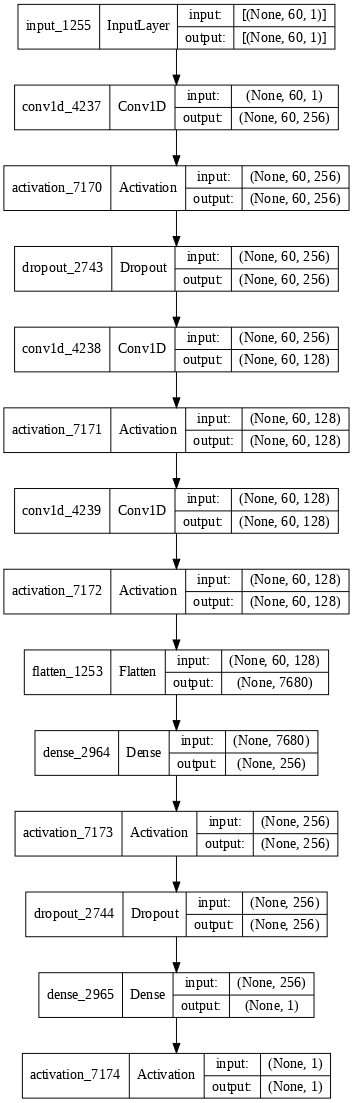

In [115]:
plot_model(model, show_shapes=True, dpi = 70)

### Обучение

In [116]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
history = model.fit(trainDataGen, epochs=15, validation_data=testDataGen)

Epoch 1/15
37/37 [==============================] - 1s 14ms/step - loss: 0.0470 - val_loss: 0.0151
Epoch 2/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0104
Epoch 3/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0124 - val_loss: 0.0061
Epoch 4/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 5/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 6/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0099 - val_loss: 0.0041
Epoch 7/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0046
Epoch 8/15
37/37 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0041
Epoch 9/15
37/37 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0033
Epoch 10/15
37/37 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 11/

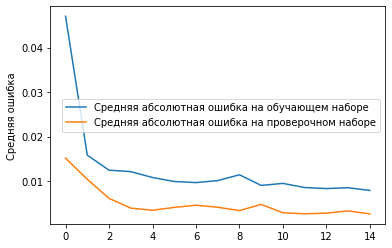

In [117]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

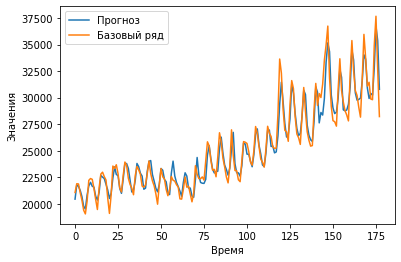

In [118]:
# Прогнозируем данные
currModel = model
predVal, yValUnscaled = getPred(currModel, xVal[0], yVal[0], Scaler)

# Отображение
showPredict(0, 400, 0, predVal, yValUnscaled)

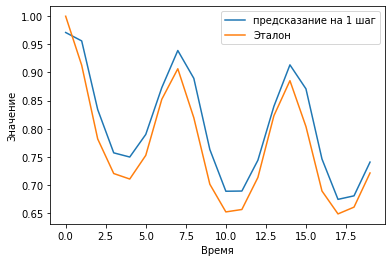

In [119]:
# Корреляция
autoCorr([0], 20, predVal, yValUnscaled)